In [4]:
from simulation.ComplexModeSimulation import ComplexModeSimulation
from model.MassExitTransaction import MassExitTransaction
import common
import matplotlib.pyplot as plt

fee_ranges = [0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 12, 14, 17, 20, 25, 30, 40, 50, 60, 70, 80, 100, 120, 140, 170, 200, 250, 300, 400, 500, 600, 700, 800, 1000, 1200, 1400, 1700, 2000, 2500, 3000, 4000, 5000, 6000, 7000, 8000, 10000 ]

mempool_data_during_congestion = common.doPreprocessing(common.get_mempool_dir_during_congestion())
mempool_data_no_congestion = common.doPreprocessing(common.get_mempool_dir_no_congestion())
blocks_data = common.get_blocks_data()
PROBLEMATIC_INTERVALS = common.get_problematic_intervals()

plt.rcParams.update({'font.size': 12})

def usesHistoricalBlocksData(scenario):
  if scenario == 1:
    return True
  else:
    return False 

In [5]:
def buildTransactions(num_attacked_channels, fee_index_attacker, initial_tx_with_same_fee_attacker, isDynamic):
    transactions = []
    attackerTx = MassExitTransaction(isAttacker=True, num=num_attacked_channels, isDynamic=False)
    attackerTx.feeIndex = fee_index_attacker
    attackerTx.txWithSameFee = initial_tx_with_same_fee_attacker
    transactions.append(attackerTx)
    for _ in range(num_attacked_channels):
        tx = MassExitTransaction(isAttacker=False, num=1, isDynamic=isDynamic)
        transactions.append(tx)
    
    return transactions  

def runSimulation(sim, transactions, num_attacked_channels, to_self_delay):
    late_penalty_transactions = 0
    confirmedAllAttackerTxLogged = False
    honestIndex = 1
    sim.submitTransaction(transactions[0]) # we submit attacker txs
    last_num_attacker_txs = transactions[0].num
        
    print("[INFO] Starting simulation...")
    
    while sim.hasSnapshots():
        nextBlock = 0 if sim.blocksCounter == 0 else sim.blocksCounter + 1
        blocksCount = sim.getNewBlocksCount(nextBlock)
        for i in range(blocksCount):
            updateSnapshot = (i == blocksCount - 1)
            sim.run(updateSnapshot=updateSnapshot)
            remainingAttackerTxs = transactions[0].num
            
            if remainingAttackerTxs == 0 and not confirmedAllAttackerTxLogged:
                print(f"[INFO] All attacker transactions mined at block #{sim.blocksCounter}")
                confirmedAllAttackerTxLogged = True
            
            num_confirmed_attacker_txs = last_num_attacker_txs - remainingAttackerTxs
            newHonestIndex = honestIndex + num_confirmed_attacker_txs

            while honestIndex < newHonestIndex:
                honestTx = transactions[honestIndex]
                honestTx.submitted = True
                txsWithNumGreaterThanOne = [0] * len(fee_ranges)
                txsWithNumGreaterThanOne[transactions[0].feeIndex] = transactions[0].num
                # with respect to the previous version of the simulation, the main thing that slightly changes results is the fee computation
                honest_fee_index, honest_fee = sim.getAverageFee(txsWithNumGreaterThanOne) # average or median ?
                honestTx.feeIndex = honest_fee_index
                honestTx.currentFee = honest_fee
                honestTx.txWithSameFee = sim.getTxWithSameFee(honest_fee_index)
                honestTx.attackerTxConfirmedBlockNumber = sim.blocksCounter
                honestIndex += 1
                sim.submitTransaction(honestTx)
            
                
            if sim.getConfirmedTxCount() == (2 * num_attacked_channels):
                print(f"[INFO] All transactions confirmed at block #{sim.blocksCounter}")
                
                for tx in transactions:
                    if (not tx.isAttacker and tx.confirmedBlockNumber - tx.attackerTxConfirmedBlockNumber) > to_self_delay: 
                        late_penalty_transactions += 1
                print(f"[INFO] {late_penalty_transactions} late penalty transactions")        
                return late_penalty_transactions

            lastHonestTx = transactions[num_attacked_channels]
            if lastHonestTx.submitted and (sim.blocksCounter - lastHonestTx._attackerTxConfirmedBlockNumber) > to_self_delay:
                print(f"[INFO] {to_self_delay} blocks have passed since the last honest tx was submitted at block #{sim.blocksCounter}, ending simulation")
                
                for tx in transactions:
                    n = tx.confirmedBlockNumber if tx.confirmed else sim.blocksCounter
                    if not tx.isAttacker and n - tx.attackerTxConfirmedBlockNumber> to_self_delay: 
                        late_penalty_transactions += 1
                print(f"[INFO] {late_penalty_transactions} late penalty transactions")        
                return late_penalty_transactions

            last_num_attacker_txs = remainingAttackerTxs
        
    print(f"[WARN] Could not finish the simulation because all the time window has passed")
    return None


def runSimulationForAttackerProfit(sim, transactions, to_self_delay, attacker_fee_second_tx, honest_index_plus_one=False, second_attacker_tx_dynamic=False):
    confirmedAllAttackerTxLogged = False
    honestIndex = 1
    sim.submitTransaction(transactions[0]) # we submit attacker txs
    last_num_attacker_txs = transactions[0].num
    secondAttackerTransactions = []
    compromised_channels = 0    
    
    checkDelayBlocks = {} # maps attacker confirmation blocks + delay to victim txs

    print("[INFO] Starting simulation...")
    
    while sim.hasSnapshots():
        nextBlock = 0 if sim.blocksCounter == 0 else sim.blocksCounter + 1
        blocksCount = sim.getNewBlocksCount(nextBlock)
        for i in range(blocksCount):
            updateSnapshot = (i == blocksCount - 1)
            sim.run(updateSnapshot=updateSnapshot)
            remainingAttackerTxs = transactions[0].num
            
            if remainingAttackerTxs == 0 and not confirmedAllAttackerTxLogged:
                print(f"[INFO] All fraudulent commitment transactions mined at block #{sim.blocksCounter}")
                confirmedAllAttackerTxLogged = True
            
            num_confirmed_attacker_txs = last_num_attacker_txs - remainingAttackerTxs
            newHonestIndex = honestIndex + num_confirmed_attacker_txs

            while honestIndex < newHonestIndex:
                if (sim.blocksCounter + to_self_delay) in checkDelayBlocks:
                    checkDelayBlocks[sim.blocksCounter + to_self_delay].append(honestIndex)
                else:
                    checkDelayBlocks[sim.blocksCounter + to_self_delay] = [honestIndex]
                honestTx = transactions[honestIndex]
                honestTx.submitted = True
                txsWithNumGreaterThanOne = [0] * len(fee_ranges)
                txsWithNumGreaterThanOne[transactions[0].feeIndex] = transactions[0].num
                honest_fee_index, honest_fee = sim.getAverageFee(txsWithNumGreaterThanOne)
                honestTx.feeIndex = honest_fee_index
                honestTx.currentFee = honest_fee
                honestTx.txWithSameFee = sim.getTxWithSameFee(honest_fee_index)
                honestTx.attackerTxConfirmedBlockNumber = sim.blocksCounter 
                honestIndex += 1
                sim.submitTransaction(honestTx)
            
            if sim.blocksCounter in checkDelayBlocks:
                tx_indexes = checkDelayBlocks[sim.blocksCounter]
                for tx_index in tx_indexes:
                    tx = transactions[tx_index]
                    if not tx.confirmed: #and sim.blocksCounter - tx.attackerTxConfirmedBlockNumber >= to_self_delay: 
                        secondAttackerTx = MassExitTransaction(True, 1, isDynamic=second_attacker_tx_dynamic) 
                        secondAttackerTx.submitted = True
                        txsWithNumGreaterThanOne = [0] * len(fee_ranges)
                        txsWithNumGreaterThanOne[transactions[0].feeIndex] = transactions[0].num
                        # with respect to the previous version of the simulation, the main thing that slightly changes results is the fee computation
                        fee_index = 0
                        if honest_index_plus_one:
                            fee_index = min(tx.feeIndex + 1, len(fee_ranges) - 1)
                        else:
                            fee_index = common.find_index_of_fee_in_ranges(attacker_fee_second_tx)
                        secondAttackerTx.feeIndex = fee_index
                        secondAttackerTx.currentFee = fee_ranges[fee_index]
                        secondAttackerTx.txWithSameFee = sim.getTxWithSameFee(fee_index)
                        secondAttackerTx.penaltyTxIndex = tx_index
                        secondAttackerTransactions.append(secondAttackerTx)
                        sim.submitTransaction(secondAttackerTx)
                checkDelayBlocks.pop(sim.blocksCounter, None)      
                    
            if transactions[0].num == 0 and sim.allUserTxsConfirmed():
                for secondAttackerTx in secondAttackerTransactions:
                    if (secondAttackerTx.confirmed and not transactions[secondAttackerTx.penaltyTxIndex].confirmed) or (secondAttackerTx.confirmed and transactions[secondAttackerTx.penaltyTxIndex].confirmed and secondAttackerTx.confirmedBlockNumber < transactions[secondAttackerTx.penaltyTxIndex].confirmedBlockNumber):
                        compromised_channels += 1
                print("Finished simulation")
                return compromised_channels
            

            last_num_attacker_txs = remainingAttackerTxs
        
    print(f"[WARN] Could not finish the simulation because all the time window has passed")
    return None        

to_self_delay: 100 blocks
[INFO] Starting simulation...
[INFO] All attacker transactions mined at block #7478
[INFO] 100 blocks have passed since the last honest tx was submitted at block #7579, ending simulation
[INFO] 58531 late penalty transactions
58531 late penalty transactions
[INFO] Starting simulation...
[INFO] All attacker transactions mined at block #7454
[INFO] 100 blocks have passed since the last honest tx was submitted at block #7555, ending simulation
[INFO] 58531 late penalty transactions
58531 late penalty transactions
[INFO] Starting simulation...
[INFO] All attacker transactions mined at block #7225
[INFO] 100 blocks have passed since the last honest tx was submitted at block #7326, ending simulation
[INFO] 58531 late penalty transactions
58531 late penalty transactions
[INFO] Starting simulation...
[INFO] All attacker transactions mined at block #7107
[INFO] 100 blocks have passed since the last honest tx was submitted at block #7208, ending simulation
[INFO] 58531 

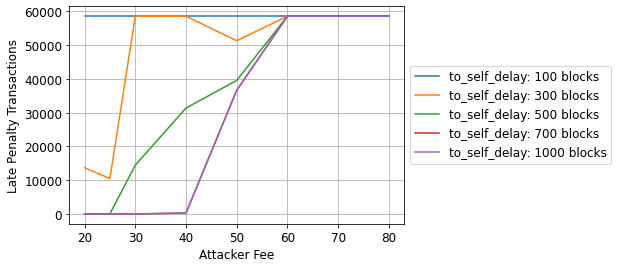

to_self_delay: 100 blocks
[INFO] Starting simulation...
[INFO] All attacker transactions mined at block #7415
[INFO] 100 blocks have passed since the last honest tx was submitted at block #7516, ending simulation
[INFO] 20084 late penalty transactions
20084 late penalty transactions
[INFO] Starting simulation...
[INFO] All attacker transactions mined at block #7289
[INFO] 100 blocks have passed since the last honest tx was submitted at block #7390, ending simulation
[INFO] 20084 late penalty transactions
20084 late penalty transactions
[INFO] Starting simulation...
[INFO] All attacker transactions mined at block #7073
[INFO] 100 blocks have passed since the last honest tx was submitted at block #7174, ending simulation
[INFO] 20084 late penalty transactions
20084 late penalty transactions
[INFO] Starting simulation...
[INFO] All attacker transactions mined at block #6948
[INFO] 100 blocks have passed since the last honest tx was submitted at block #7049, ending simulation
[INFO] 20084 

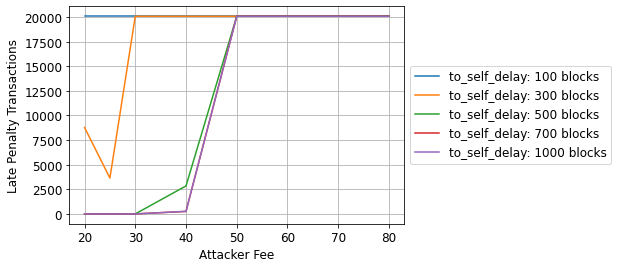

to_self_delay: 100 blocks
[INFO] Starting simulation...
[INFO] All attacker transactions mined at block #29
[INFO] All transactions confirmed at block #81
[INFO] 0 late penalty transactions
0 late penalty transactions
[INFO] Starting simulation...
[INFO] All attacker transactions mined at block #29
[INFO] All transactions confirmed at block #77
[INFO] 0 late penalty transactions
0 late penalty transactions
[INFO] Starting simulation...
[INFO] All attacker transactions mined at block #29
[INFO] All transactions confirmed at block #79
[INFO] 0 late penalty transactions
0 late penalty transactions
[INFO] Starting simulation...
[INFO] All attacker transactions mined at block #29
[INFO] All transactions confirmed at block #73
[INFO] 0 late penalty transactions
0 late penalty transactions
[INFO] Starting simulation...
[INFO] All attacker transactions mined at block #29
[INFO] All transactions confirmed at block #62
[INFO] 0 late penalty transactions
0 late penalty transactions
[INFO] Startin

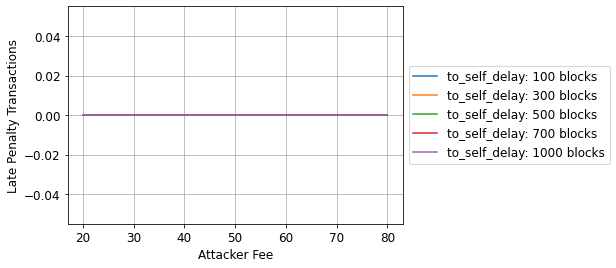

In [6]:
ln_delays = [100, 300, 500, 700, 1000]

experiments = []
experiments.append({
    "n_attacked_channels" : common.get_lwmc_max_edges(),
    "scenario" : 1
})
experiments.append({
    "n_attacked_channels" : common.get_lwmc_results()[30]["n_edges"],
    "scenario" : 1
})
experiments.append({
    "n_attacked_channels" : common.get_lwmc_max_edges(),
    "scenario" : 2
})

for experiment in experiments:
    fig, ax = plt.subplots()
    ax.grid(True)
    labels = []

    n_attacked_channels = experiment["n_attacked_channels"]
    scenario = experiment["scenario"]
    mempool_data = mempool_data_during_congestion if scenario == 1 else mempool_data_no_congestion
    use_historical_blocks_data = usesHistoricalBlocksData(scenario=scenario)
    first_block_height = common.get_first_block_height_during_congestion() if scenario == 1 else common.get_first_block_height_no_congestion()

    for ln_delay in ln_delays:
        print(f"to_self_delay: {ln_delay} blocks")
        y = []
        x = []

        i = 13
        fee_ranges2 = [ 0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 12, 14, 17, 20, 25, 30, 40, 50, 60, 70, 80 ]
        while(i < len(fee_ranges2)):
            sim = ComplexModeSimulation(
                mempoolData=mempool_data, 
                blocksData=blocks_data, 
                isDynamic=False, 
                useHistoricalBlocksData=use_historical_blocks_data,
                firstBlockHeightOfSimulation=first_block_height, 
                problematicIntervals=PROBLEMATIC_INTERVALS, 
                step=-1, 
                beta=-1)
            transactions = buildTransactions(n_attacked_channels, i, (sim.getFirstSnapshot())[1][i], False)
            n = runSimulation(sim, transactions, n_attacked_channels, ln_delay)
            print(f"{n} late penalty transactions")
            y.append(n)
            x.append(fee_ranges2[i])
            i += 1
        
        plt.plot(x, y)   
        labels.append(f"to_self_delay: {ln_delay} blocks") 

    plt.xlabel('Attacker Fee', fontsize=12) 
    plt.ylabel(f'Late Penalty Transactions', fontsize=12)
    plt.legend(labels=labels, loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()

to_self_delay: 100 blocks
[INFO] Starting simulation...
[INFO] All fraudulent commitment transactions mined at block #7538
Finished simulation
58531 compromised channels
[INFO] Starting simulation...
[INFO] All fraudulent commitment transactions mined at block #7504
Finished simulation
58531 compromised channels
[INFO] Starting simulation...
[INFO] All fraudulent commitment transactions mined at block #7483
Finished simulation
58531 compromised channels
[INFO] Starting simulation...
[INFO] All fraudulent commitment transactions mined at block #7443
Finished simulation
58531 compromised channels
[INFO] Starting simulation...
[INFO] All fraudulent commitment transactions mined at block #7211
Finished simulation
58531 compromised channels
[INFO] Starting simulation...
[INFO] All fraudulent commitment transactions mined at block #6911
Finished simulation
58531 compromised channels
[INFO] Starting simulation...
[INFO] All fraudulent commitment transactions mined at block #3837
Finished simu

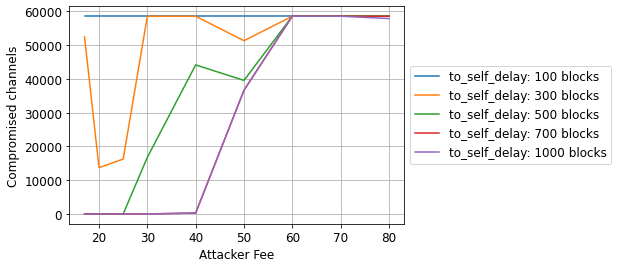

to_self_delay: 100 blocks
[INFO] Starting simulation...
[INFO] All fraudulent commitment transactions mined at block #7450
Finished simulation
20084 compromised channels
[INFO] Starting simulation...
[INFO] All fraudulent commitment transactions mined at block #7443
Finished simulation
20084 compromised channels
[INFO] Starting simulation...
[INFO] All fraudulent commitment transactions mined at block #7306
Finished simulation
20084 compromised channels
[INFO] Starting simulation...
[INFO] All fraudulent commitment transactions mined at block #7110
Finished simulation
20084 compromised channels
[INFO] Starting simulation...
[INFO] All fraudulent commitment transactions mined at block #6948
Finished simulation
20084 compromised channels
[INFO] Starting simulation...
[INFO] All fraudulent commitment transactions mined at block #3832
Finished simulation
20084 compromised channels
[INFO] Starting simulation...
[INFO] All fraudulent commitment transactions mined at block #3764
Finished simu

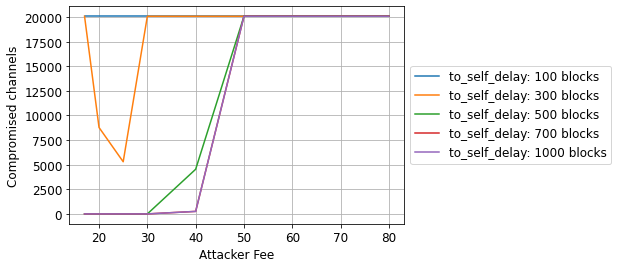

to_self_delay: 100 blocks
[INFO] Starting simulation...
[INFO] All fraudulent commitment transactions mined at block #30
Finished simulation
0 compromised channels
[INFO] Starting simulation...
[INFO] All fraudulent commitment transactions mined at block #29
Finished simulation
0 compromised channels
[INFO] Starting simulation...
[INFO] All fraudulent commitment transactions mined at block #29
Finished simulation
0 compromised channels
[INFO] Starting simulation...
[INFO] All fraudulent commitment transactions mined at block #29
Finished simulation
0 compromised channels
[INFO] Starting simulation...
[INFO] All fraudulent commitment transactions mined at block #29
Finished simulation
0 compromised channels
[INFO] Starting simulation...
[INFO] All fraudulent commitment transactions mined at block #29
Finished simulation
0 compromised channels
[INFO] Starting simulation...
[INFO] All fraudulent commitment transactions mined at block #29
Finished simulation
0 compromised channels
[INFO] S

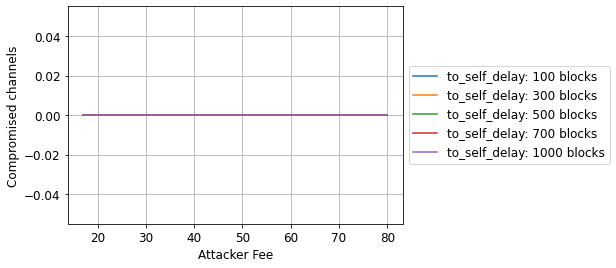

In [7]:
ln_delays = [100, 300, 500, 700, 1000]

experiments = []
experiments.append({
    "n_attacked_channels" : common.get_lwmc_max_edges(),
    "scenario" : 1
})
experiments.append({
    "n_attacked_channels" : common.get_lwmc_results()[30]["n_edges"],
    "scenario" : 1
})
experiments.append({
    "n_attacked_channels" : common.get_lwmc_max_edges(),
    "scenario" : 2
})

for experiment in experiments:
    fig, ax = plt.subplots()
    ax.grid(True)
    labels = []

    n_attacked_channels = experiment["n_attacked_channels"]
    scenario = experiment["scenario"]
    mempool_data = mempool_data_during_congestion if scenario == 1 else mempool_data_no_congestion
    use_historical_blocks_data = usesHistoricalBlocksData(scenario=scenario)
    first_block_height = common.get_first_block_height_during_congestion() if scenario == 1 else common.get_first_block_height_no_congestion()

    for ln_delay in ln_delays:
        print(f"to_self_delay: {ln_delay} blocks")
        y = []
        x = []

        i = 12
        fee_ranges2 = [ 0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 12, 14, 17, 20, 25, 30, 40, 50, 60, 70, 80 ]
        while(i < len(fee_ranges2)):
            sim = ComplexModeSimulation(
                mempoolData=mempool_data, 
                blocksData=blocks_data, 
                isDynamic=False, 
                useHistoricalBlocksData=use_historical_blocks_data,
                firstBlockHeightOfSimulation=first_block_height, 
                problematicIntervals=PROBLEMATIC_INTERVALS, 
                step=-1, 
                beta=-1)
            transactions = buildTransactions(n_attacked_channels, i, (sim.getFirstSnapshot())[1][i], False)
            n = runSimulationForAttackerProfit(sim, transactions, ln_delay, attacker_fee_second_tx=100, second_attacker_tx_dynamic=False) 
            print(f"{n} compromised channels")
            y.append(n)
            x.append(fee_ranges2[i])
            i += 1
        
        plt.plot(x, y)   
        labels.append(f"to_self_delay: {ln_delay} blocks") 

    plt.xlabel('Attacker Fee', fontsize=12) 
    plt.ylabel(f'Compromised channels', fontsize=12)
    plt.legend(labels=labels, loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()

step = 1, attacker fee=20
[INFO] Starting simulation...
[INFO] All attacker transactions mined at block #7549
[INFO] All transactions confirmed at block #7607
[INFO] 0 late penalty transactions
step = 10, attacker fee=20
[INFO] Starting simulation...
[INFO] All attacker transactions mined at block #7478
[INFO] All transactions confirmed at block #7723
[INFO] 0 late penalty transactions
step = 20, attacker fee=20
[INFO] Starting simulation...
[INFO] All attacker transactions mined at block #7478
[INFO] All transactions confirmed at block #7765
[INFO] 0 late penalty transactions
step = 30, attacker fee=20
[INFO] Starting simulation...
[INFO] All attacker transactions mined at block #7478
[INFO] All transactions confirmed at block #7796
[INFO] 0 late penalty transactions
step = 40, attacker fee=20
[INFO] Starting simulation...
[INFO] All attacker transactions mined at block #7478
[INFO] All transactions confirmed at block #7771
[INFO] 0 late penalty transactions
step = 50, attacker fee=20

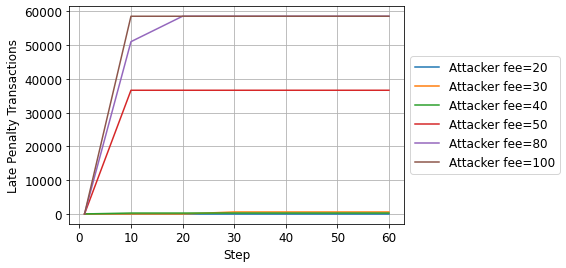

step = 1, attacker fee=20
[INFO] Starting simulation...
[INFO] All attacker transactions mined at block #7443
[INFO] All transactions confirmed at block #7513
[INFO] 0 late penalty transactions
step = 10, attacker fee=20
[INFO] Starting simulation...
[INFO] All attacker transactions mined at block #7415
[INFO] All transactions confirmed at block #7576
[INFO] 0 late penalty transactions
step = 20, attacker fee=20
[INFO] Starting simulation...
[INFO] All attacker transactions mined at block #7415
[INFO] All transactions confirmed at block #7718
[INFO] 0 late penalty transactions
step = 30, attacker fee=20
[INFO] Starting simulation...
[INFO] All attacker transactions mined at block #7415
[INFO] All transactions confirmed at block #7723
[INFO] 0 late penalty transactions
step = 40, attacker fee=20
[INFO] Starting simulation...
[INFO] All attacker transactions mined at block #7415
[INFO] All transactions confirmed at block #7724
[INFO] 0 late penalty transactions
step = 50, attacker fee=20

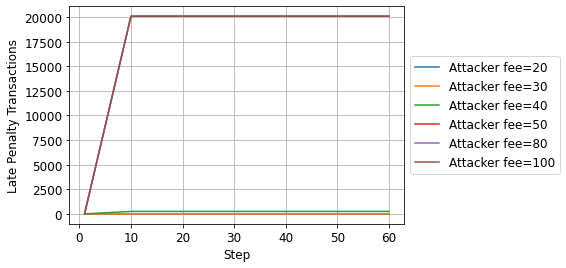

step = 1, attacker fee=20
[INFO] Starting simulation...
[INFO] All attacker transactions mined at block #29
[INFO] All transactions confirmed at block #69
[INFO] 0 late penalty transactions
step = 10, attacker fee=20
[INFO] Starting simulation...
[INFO] All attacker transactions mined at block #29
[INFO] All transactions confirmed at block #81
[INFO] 0 late penalty transactions
step = 20, attacker fee=20
[INFO] Starting simulation...
[INFO] All attacker transactions mined at block #29
[INFO] All transactions confirmed at block #81
[INFO] 0 late penalty transactions
step = 30, attacker fee=20
[INFO] Starting simulation...
[INFO] All attacker transactions mined at block #29
[INFO] All transactions confirmed at block #81
[INFO] 0 late penalty transactions
step = 40, attacker fee=20
[INFO] Starting simulation...
[INFO] All attacker transactions mined at block #29
[INFO] All transactions confirmed at block #81
[INFO] 0 late penalty transactions
step = 50, attacker fee=20
[INFO] Starting sim

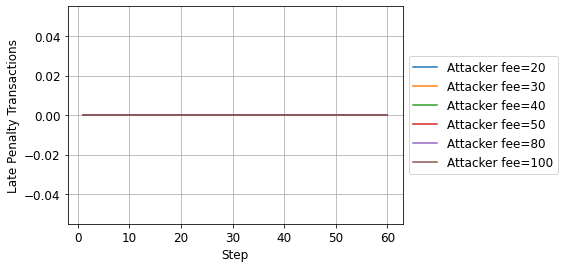

In [8]:
ln_delay = 539
attacker_fees = [20, 30, 40, 50, 80, 100]

experiments = []
experiments.append({
    "n_attacked_channels" : common.get_lwmc_max_edges(),
    "scenario" : 1
})
experiments.append({
    "n_attacked_channels" : common.get_lwmc_results()[30]["n_edges"],
    "scenario" : 1
})
experiments.append({
    "n_attacked_channels" : common.get_lwmc_max_edges(),
    "scenario" : 2
})

beta = 1.01
#steps = [1, 5, 10, 15, 20, 30, 40, 50, 60] 
steps = [1, 10, 20, 30, 40, 50, 60] 

for experiment in experiments:
    fig, ax = plt.subplots()
    ax.grid(True)
    labels = []

    n_attacked_channels = experiment["n_attacked_channels"]
    scenario = experiment["scenario"]
    mempool_data = mempool_data_during_congestion if scenario == 1 else mempool_data_no_congestion
    use_historical_blocks_data = usesHistoricalBlocksData(scenario=scenario)
    first_block_height = common.get_first_block_height_during_congestion() if scenario == 1 else common.get_first_block_height_no_congestion()

    for attacker_fee in attacker_fees:
        fee_index = common.find_index_of_fee_in_ranges(attacker_fee)
        y = []
        x = []
        for step in steps:
            print(f"step = {step}, attacker fee={attacker_fee}")
            sim = ComplexModeSimulation(
                mempoolData=mempool_data, 
                blocksData=blocks_data, 
                isDynamic=True, 
                useHistoricalBlocksData=use_historical_blocks_data,
                firstBlockHeightOfSimulation=first_block_height, 
                problematicIntervals=PROBLEMATIC_INTERVALS,
                step=step, 
                beta=beta)
            transactions = buildTransactions(n_attacked_channels, fee_index, (sim.getFirstSnapshot())[1][fee_index], True)
            n = runSimulation(sim, transactions, n_attacked_channels, ln_delay)
            y.append(n)
            x.append(step)
        plt.plot(x, y)   
        labels.append(f"Attacker fee={attacker_fee}") 
        i += 1

    plt.xlabel('Step', fontsize=12) 
    plt.ylabel(f'Late Penalty Transactions', fontsize=12)
    plt.legend(labels=labels, loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()

[INFO] Starting simulation...
[INFO] All attacker transactions mined at block #7561
[INFO] All transactions confirmed at block #7654
[INFO] 0 late penalty transactions
[INFO] Starting simulation...
[INFO] All attacker transactions mined at block #7549
[INFO] All transactions confirmed at block #7607
[INFO] 0 late penalty transactions
[INFO] Starting simulation...
[INFO] All attacker transactions mined at block #7480
[INFO] All transactions confirmed at block #7551
[INFO] 0 late penalty transactions
[INFO] Starting simulation...
[INFO] All attacker transactions mined at block #7452
[INFO] All transactions confirmed at block #7540
[INFO] 0 late penalty transactions
[INFO] Starting simulation...
[INFO] All attacker transactions mined at block #7277
[INFO] All transactions confirmed at block #7407
[INFO] 0 late penalty transactions
[INFO] Starting simulation...
[INFO] All attacker transactions mined at block #6915
[INFO] All transactions confirmed at block #6991
[INFO] 0 late penalty trans

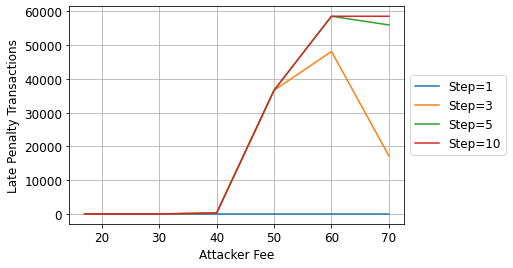

[INFO] Starting simulation...
[INFO] All attacker transactions mined at block #7452
[INFO] All transactions confirmed at block #7527
[INFO] 0 late penalty transactions
[INFO] Starting simulation...
[INFO] All attacker transactions mined at block #7443
[INFO] All transactions confirmed at block #7513
[INFO] 0 late penalty transactions
[INFO] Starting simulation...
[INFO] All attacker transactions mined at block #7319
[INFO] All transactions confirmed at block #7423
[INFO] 0 late penalty transactions
[INFO] Starting simulation...
[INFO] All attacker transactions mined at block #7119
[INFO] All transactions confirmed at block #7209
[INFO] 0 late penalty transactions
[INFO] Starting simulation...
[INFO] All attacker transactions mined at block #6948
[INFO] All transactions confirmed at block #7097
[INFO] 0 late penalty transactions
[INFO] Starting simulation...
[INFO] All attacker transactions mined at block #3832
[INFO] All transactions confirmed at block #4084
[INFO] 0 late penalty trans

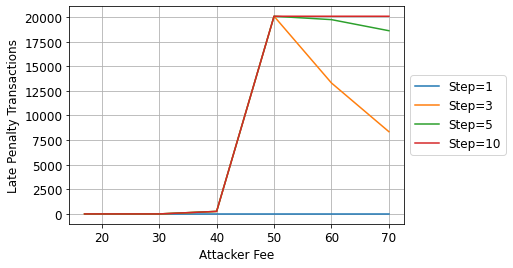

[INFO] Starting simulation...
[INFO] All attacker transactions mined at block #34
[INFO] All transactions confirmed at block #80
[INFO] 0 late penalty transactions
[INFO] Starting simulation...
[INFO] All attacker transactions mined at block #29
[INFO] All transactions confirmed at block #69
[INFO] 0 late penalty transactions
[INFO] Starting simulation...
[INFO] All attacker transactions mined at block #30
[INFO] All transactions confirmed at block #68
[INFO] 0 late penalty transactions
[INFO] Starting simulation...
[INFO] All attacker transactions mined at block #29
[INFO] All transactions confirmed at block #63
[INFO] 0 late penalty transactions
[INFO] Starting simulation...
[INFO] All attacker transactions mined at block #29
[INFO] All transactions confirmed at block #62
[INFO] 0 late penalty transactions
[INFO] Starting simulation...
[INFO] All attacker transactions mined at block #30
[INFO] All transactions confirmed at block #61
[INFO] 0 late penalty transactions
[INFO] Starting 

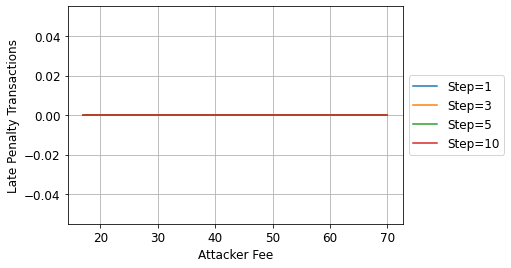

In [9]:
ln_delay = 539

experiments = []
experiments.append({
    "n_attacked_channels" : common.get_lwmc_max_edges(),
    "scenario" : 1
})
experiments.append({
    "n_attacked_channels" : common.get_lwmc_results()[30]["n_edges"],
    "scenario" : 1
})
experiments.append({
    "n_attacked_channels" : common.get_lwmc_max_edges(),
    "scenario" : 2
})

beta = 1.01
steps = [1, 3, 5, 10]

for experiment in experiments:
    fig, ax = plt.subplots()
    ax.grid(True)
    labels = []

    n_attacked_channels = experiment["n_attacked_channels"]
    scenario = experiment["scenario"]
    mempool_data = mempool_data_during_congestion if scenario == 1 else mempool_data_no_congestion
    use_historical_blocks_data = usesHistoricalBlocksData(scenario=scenario)
    first_block_height = common.get_first_block_height_during_congestion() if scenario == 1 else common.get_first_block_height_no_congestion()

    for step in steps: 
        y = []
        x = []
        i = 12 
        fee_ranges2 = [ 0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 12, 14, 17, 20, 25, 30, 40, 50, 60, 70]
        while(i < len(fee_ranges2)):
            sim = ComplexModeSimulation(
                mempoolData=mempool_data, 
                blocksData=blocks_data, 
                isDynamic=True, 
                useHistoricalBlocksData=use_historical_blocks_data,
                firstBlockHeightOfSimulation=first_block_height, 
                problematicIntervals=PROBLEMATIC_INTERVALS, 
                step=step, 
                beta=beta)
            transactions = buildTransactions(n_attacked_channels, i, (sim.getFirstSnapshot())[1][i], True)
            n = runSimulation(sim, transactions, n_attacked_channels, ln_delay)
            y.append(n)
            x.append(fee_ranges2[i])
            i += 1
        plt.plot(x, y)   
        labels.append(f"Step={step}") 

    plt.xlabel('Attacker Fee', fontsize=12) 
    plt.ylabel(f'Late Penalty Transactions', fontsize=12)
    plt.legend(labels=labels, loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()

[INFO] Starting simulation...
[INFO] All fraudulent commitment transactions mined at block #7561
Finished simulation
step=1, attacker fee index=12, 0 compromised channels
[INFO] Starting simulation...
[INFO] All fraudulent commitment transactions mined at block #7549
Finished simulation
step=1, attacker fee index=13, 0 compromised channels
[INFO] Starting simulation...
[INFO] All fraudulent commitment transactions mined at block #7480
Finished simulation
step=1, attacker fee index=14, 0 compromised channels
[INFO] Starting simulation...
[INFO] All fraudulent commitment transactions mined at block #7452
Finished simulation
step=1, attacker fee index=15, 0 compromised channels
[INFO] Starting simulation...
[INFO] All fraudulent commitment transactions mined at block #7277
Finished simulation
step=1, attacker fee index=16, 0 compromised channels
[INFO] Starting simulation...
[INFO] All fraudulent commitment transactions mined at block #6915
Finished simulation
step=1, attacker fee index=1

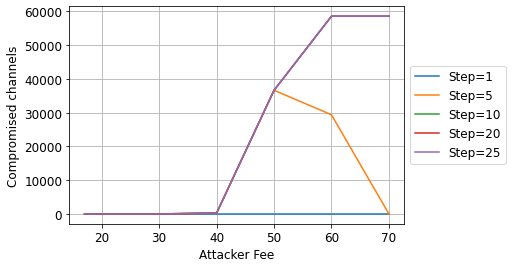

[INFO] Starting simulation...
[INFO] All fraudulent commitment transactions mined at block #7452
Finished simulation
step=1, attacker fee index=12, 0 compromised channels
[INFO] Starting simulation...
[INFO] All fraudulent commitment transactions mined at block #7443
Finished simulation
step=1, attacker fee index=13, 0 compromised channels
[INFO] Starting simulation...
[INFO] All fraudulent commitment transactions mined at block #7319
Finished simulation
step=1, attacker fee index=14, 0 compromised channels
[INFO] Starting simulation...
[INFO] All fraudulent commitment transactions mined at block #7119
Finished simulation
step=1, attacker fee index=15, 0 compromised channels
[INFO] Starting simulation...
[INFO] All fraudulent commitment transactions mined at block #6948
Finished simulation
step=1, attacker fee index=16, 0 compromised channels
[INFO] Starting simulation...
[INFO] All fraudulent commitment transactions mined at block #3832
Finished simulation
step=1, attacker fee index=1

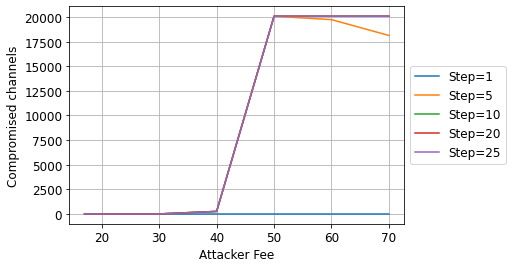

[INFO] Starting simulation...
[INFO] All fraudulent commitment transactions mined at block #34
Finished simulation
step=1, attacker fee index=12, 0 compromised channels
[INFO] Starting simulation...
[INFO] All fraudulent commitment transactions mined at block #29
Finished simulation
step=1, attacker fee index=13, 0 compromised channels
[INFO] Starting simulation...
[INFO] All fraudulent commitment transactions mined at block #30
Finished simulation
step=1, attacker fee index=14, 0 compromised channels
[INFO] Starting simulation...
[INFO] All fraudulent commitment transactions mined at block #29
Finished simulation
step=1, attacker fee index=15, 0 compromised channels
[INFO] Starting simulation...
[INFO] All fraudulent commitment transactions mined at block #29
Finished simulation
step=1, attacker fee index=16, 0 compromised channels
[INFO] Starting simulation...
[INFO] All fraudulent commitment transactions mined at block #30
Finished simulation
step=1, attacker fee index=17, 0 comprom

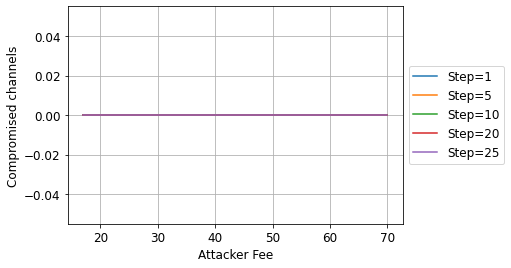

In [10]:
ln_delay = 539

experiments = []
experiments.append({
    "n_attacked_channels" : common.get_lwmc_max_edges(),
    "scenario" : 1
})
experiments.append({
    "n_attacked_channels" : common.get_lwmc_results()[30]["n_edges"],
    "scenario" : 1
})
experiments.append({
    "n_attacked_channels" : common.get_lwmc_max_edges(),
    "scenario" : 2
})

beta = 1.01
steps = [1, 5, 10, 20, 25]

for experiment in experiments:
    fig, ax = plt.subplots()
    ax.grid(True)
    labels = []

    n_attacked_channels = experiment["n_attacked_channels"]
    scenario = experiment["scenario"]
    mempool_data = mempool_data_during_congestion if scenario == 1 else mempool_data_no_congestion
    use_historical_blocks_data = usesHistoricalBlocksData(scenario=scenario)
    first_block_height = common.get_first_block_height_during_congestion() if scenario == 1 else common.get_first_block_height_no_congestion()

    for step in steps:
        y = []
        x = []
        i = 12 
        fee_ranges2 = [ 0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 12, 14, 17, 20, 25, 30, 40, 50, 60, 70]#, 80, 100 ]
        while(i < len(fee_ranges2)):
            sim = ComplexModeSimulation(
                mempoolData=mempool_data, 
                blocksData=blocks_data, 
                isDynamic=True, 
                useHistoricalBlocksData=use_historical_blocks_data,
                firstBlockHeightOfSimulation=first_block_height, 
                problematicIntervals=PROBLEMATIC_INTERVALS, 
                step=step, 
                beta=beta)
            transactions = buildTransactions(n_attacked_channels, i, (sim.getFirstSnapshot())[1][i], True)
            n = runSimulationForAttackerProfit(sim, transactions, ln_delay, attacker_fee_second_tx=100, second_attacker_tx_dynamic=True)
            print(f"step={step}, attacker fee index={i}, {n} compromised channels")
            y.append(n)
            x.append(fee_ranges2[i])
            i += 1
        plt.plot(x, y)   
        labels.append(f"Step={step}") 

    plt.xlabel('Attacker Fee', fontsize=12) 
    plt.ylabel(f'Compromised channels', fontsize=12)
    plt.legend(labels=labels, loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()

[INFO] Starting simulation...
[INFO] All fraudulent commitment transactions mined at block #7452
Finished simulation
step=1, attacker fee index=12, 0 compromised channels
[INFO] Starting simulation...
[INFO] All fraudulent commitment transactions mined at block #7443
Finished simulation
step=1, attacker fee index=13, 0 compromised channels
[INFO] Starting simulation...
[INFO] All fraudulent commitment transactions mined at block #7319
Finished simulation
step=1, attacker fee index=14, 0 compromised channels
[INFO] Starting simulation...
[INFO] All fraudulent commitment transactions mined at block #7119
Finished simulation
step=1, attacker fee index=15, 0 compromised channels
[INFO] Starting simulation...
[INFO] All fraudulent commitment transactions mined at block #6948
Finished simulation
step=1, attacker fee index=16, 0 compromised channels
[INFO] Starting simulation...
[INFO] All fraudulent commitment transactions mined at block #3832
Finished simulation
step=1, attacker fee index=1

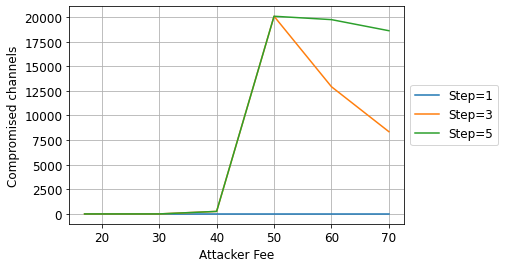

[INFO] Starting simulation...
[INFO] All fraudulent commitment transactions mined at block #7452
Finished simulation
step=1, attacker fee index=12, 0 compromised channels
[INFO] Starting simulation...
[INFO] All fraudulent commitment transactions mined at block #7443
Finished simulation
step=1, attacker fee index=13, 0 compromised channels
[INFO] Starting simulation...
[INFO] All fraudulent commitment transactions mined at block #7319
Finished simulation
step=1, attacker fee index=14, 0 compromised channels
[INFO] Starting simulation...
[INFO] All fraudulent commitment transactions mined at block #7119
Finished simulation
step=1, attacker fee index=15, 0 compromised channels
[INFO] Starting simulation...
[INFO] All fraudulent commitment transactions mined at block #6948
Finished simulation
step=1, attacker fee index=16, 0 compromised channels
[INFO] Starting simulation...
[INFO] All fraudulent commitment transactions mined at block #3832
Finished simulation
step=1, attacker fee index=1

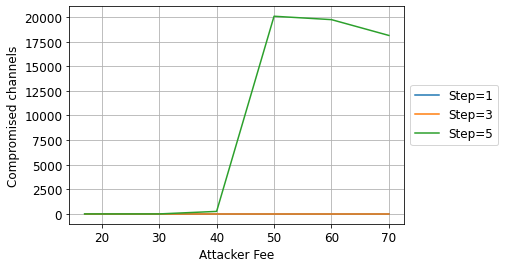

In [13]:
ln_delay = 539

experiments = []

experiments.append({
    "n_attacked_channels" : common.get_lwmc_results()[30]["n_edges"],
    "scenario" : 1,
})

experiments.append({
    "n_attacked_channels" : common.get_lwmc_results()[30]["n_edges"],
    "scenario" : 1,
    "second_attacker_txs_fee": 100
})


beta = 1.01
steps = [1, 3, 5] 

for experiment in experiments:
    fig, ax = plt.subplots()
    ax.grid(True)
    labels = []

    n_attacked_channels = experiment["n_attacked_channels"]
    scenario = experiment["scenario"]
    mempool_data = mempool_data_during_congestion if scenario == 1 else mempool_data_no_congestion
    use_historical_blocks_data = usesHistoricalBlocksData(scenario=scenario)
    first_block_height = common.get_first_block_height_during_congestion() if scenario == 1 else common.get_first_block_height_no_congestion()
    second_attacker_txs_fee = experiment["second_attacker_txs_fee"] if "second_attacker_txs_fee" in experiment else -1

    for step in steps: 
        y = []
        x = []
        i = 12 
        fee_ranges2 = [ 0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 12, 14, 17, 20, 25, 30, 40, 50, 60, 70]
        while(i < len(fee_ranges2)):
            sim = ComplexModeSimulation(
                mempoolData=mempool_data, 
                blocksData=blocks_data, 
                isDynamic=True, 
                useHistoricalBlocksData=use_historical_blocks_data,
                firstBlockHeightOfSimulation=first_block_height, 
                problematicIntervals=PROBLEMATIC_INTERVALS, 
                step=step, 
                beta=beta)
            transactions = buildTransactions(n_attacked_channels, i, (sim.getFirstSnapshot())[1][i], True)
            n = runSimulationForAttackerProfit(sim, transactions, ln_delay, attacker_fee_second_tx=second_attacker_txs_fee, honest_index_plus_one=(second_attacker_txs_fee==-1), second_attacker_tx_dynamic=True)
            print(f"step={step}, attacker fee index={i}, {n} compromised channels")
            y.append(n)
            x.append(fee_ranges2[i])
            i += 1
        plt.plot(x, y)   
        labels.append(f"Step={step}") 

    plt.xlabel('Attacker Fee', fontsize=12) 
    plt.ylabel(f'Compromised channels', fontsize=12)
    plt.legend(labels=labels, loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()

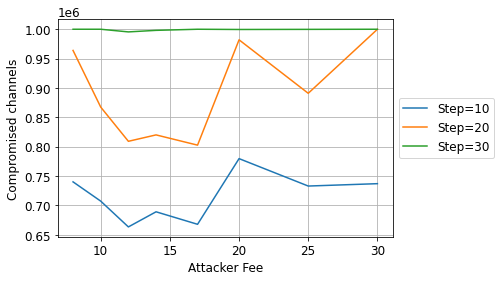

In [12]:
import json

ln_delay = 539

experiments = []

# Experiments done with honest fee index + 1 + dynamic strategy for the second honest tx
experiments.append({
    #"second_attacker_txs_fee": 1, #100, # results in file are for honest index plus one
    "n_attacked_channels" : 1000000,
    "scenario" : 1,
    "fee_per_step":{ # indices
        10: [8, 9, 10, 11, 12, 13, 14, 15],#[8, 9, 10, 11, 12, 13, 14, 15], #[1, 2, 3, 4, 5, 6, 7],#[8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19],
        20: [8, 9, 10, 11, 12, 13, 14, 15],#[8, 9, 10, 11, 12, 13, 14, 15], #[1, 2, 3, 4, 5, 6, 7],#[8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19],
        30: [8, 9, 10, 11, 12, 13, 14, 15]#[8, 9, 10, 11, 12, 13, 14, 15], #[1, 2, 3, 4, 5, 6, 7]#[8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
    }
})

data = {}
output_file = "output-1million.json" # -second-attacker-fee-100
f = open(output_file) 
data = json.load(f)
f.close()

beta = 1.01
steps = [10, 20, 30] 

for experiment in experiments:
    fig, ax = plt.subplots()
    ax.grid(True)
    labels = []

    n_attacked_channels = experiment["n_attacked_channels"]
    scenario = experiment["scenario"]
    mempool_data = mempool_data_during_congestion if scenario == 1 else mempool_data_no_congestion
    use_historical_blocks_data = usesHistoricalBlocksData(scenario=scenario)
    first_block_height = common.get_first_block_height_during_congestion() if scenario == 1 else common.get_first_block_height_no_congestion()
    second_attacker_txs_fee = experiment["second_attacker_txs_fee"] if "second_attacker_txs_fee" in experiment else -1

    for step in steps: 
        y = []
        x = []
        fee_indices = experiment["fee_per_step"][step]
        for i in fee_indices:
            n = 0
            if str(step) in data and str(fee_ranges[i]) in data[str(step)]:
                n = data[str(step)][str(fee_ranges[i])]
            else:    
                sim = ComplexModeSimulation(
                    mempoolData=mempool_data, 
                    blocksData=blocks_data, 
                    isDynamic=True, 
                    useHistoricalBlocksData=use_historical_blocks_data, 
                    firstBlockHeightOfSimulation=first_block_height, 
                    problematicIntervals=PROBLEMATIC_INTERVALS, 
                    step=step, 
                    beta=beta)
                    
                transactions = buildTransactions(n_attacked_channels, i, (sim.getFirstSnapshot())[1][i], True)
                n = runSimulationForAttackerProfit(sim, transactions, ln_delay, attacker_fee_second_tx=second_attacker_txs_fee, honest_index_plus_one=(second_attacker_txs_fee==-1), second_attacker_tx_dynamic=True)
                if n is not None:
                    if not str(step) in data:
                        data[str(step)] = {}
                    data[str(step)][str(fee_ranges[i])] = n

                    with open(output_file, 'w') as outfile:
                        json.dump(data, outfile)
            
            y.append(n)
            x.append(fee_ranges[i])
        plt.plot(x, y)   
        labels.append(f"Step={step}") 

    plt.xlabel('Attacker Fee', fontsize=12) 
    plt.ylabel(f'Compromised channels', fontsize=12)
    plt.legend(labels=labels, loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()